Creating chirped grating with 600 domains...
Initial width: 3.6 μm, Chirp rate: 0.0001
Temperature: 70.0°C
Wavelength range: 0.931-1.066 μm
Generated superlattice with 600 domains
Total grating length: 1966.92 μm


Running SHG simulation...


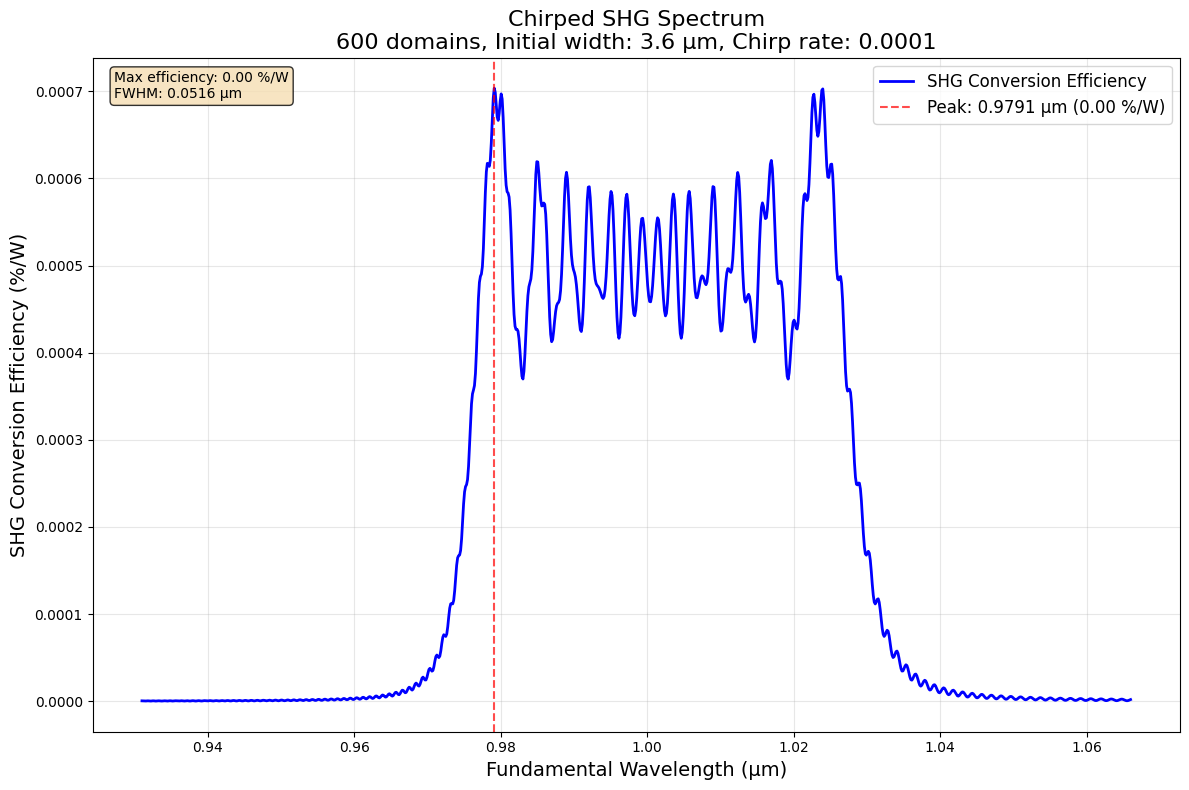


Simulation Results:
Peak wavelength: 0.9791 μm
Peak efficiency: 0.00 %/W
Maximum efficiency: 0.00 %/W
Minimum efficiency: 0.00 %/W
FWHM: 0.0516 μm


In [1]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import jit, vmap

from qpm import cwes, grating, mgoslt


def simulate_shg_spectrum(superlattice: jnp.ndarray, wavelengths: jnp.ndarray, temperature: float) -> jnp.ndarray:
    """Calculate SHG efficiency spectrum for all wavelengths."""
    # Calculate phase mismatch for all wavelengths at once
    # For SHG: delta_k = k_2w - 2*k_w (wl1=wl2=wavelength)
    delta_k_values = mgoslt.calc_twm_delta_k(wavelengths, wavelengths, temperature)

    def single_wavelength_shg(delta_k: jnp.ndarray) -> jnp.ndarray:
        """Calculate SHG efficiency for a single delta_k value."""
        b_initial = jnp.array([1.0, 0.0, 0.0], dtype=jnp.complex64)
        b_final = cwes.simulate_twm(superlattice, delta_k, delta_k, b_initial)
        return jnp.abs(b_final[1]) ** 2

    vmapped_shg = jit(vmap(single_wavelength_shg))
    return vmapped_shg(delta_k_values)


def main() -> None:
    """Main function to run the chirped SHG simulation and plot results."""
    # --- Parameters ---
    num_domains = 600
    initial_width = 3.6  # μm
    chirp_rate = 0.0001  # chirp rate
    kappa_mag = 1.31e-5  # Nonlinear coupling coefficient magnitude
    temperature = 70.0  # Operating temperature (°C)

    # Wavelength range
    wl_start, wl_end = 0.931, 1.066
    num_points = 1000

    print(f"Creating chirped grating with {num_domains} domains...")
    print(f"Initial width: {initial_width} μm, Chirp rate: {chirp_rate}")
    print(f"Temperature: {temperature}°C")
    print(f"Wavelength range: {wl_start}-{wl_end} μm")

    # Create the chirped grating
    profile = grating.tapered_profile(num_domains, initial_width, chirp_rate, kappa_mag)
    superlattice = grating.build(profile)

    print(f"Generated superlattice with {len(superlattice)} domains")
    print(f"Total grating length: {jnp.sum(superlattice[:, 0]):.2f} μm")
    grating.plot_section_array(superlattice, mode="spectrum")

    # Create wavelength array
    wavelengths = jnp.linspace(wl_start, wl_end, num_points)

    # Run simulation
    print("Running SHG simulation...")
    efficiencies = simulate_shg_spectrum(superlattice, wavelengths, temperature)

    # Convert to percentage
    efficiencies_percent = efficiencies * 100

    # Plot results
    plt.figure(figsize=(12, 8))
    plt.plot(wavelengths, efficiencies_percent, "b-", linewidth=2, label="SHG Conversion Efficiency")
    plt.xlabel("Fundamental Wavelength (μm)", fontsize=14)
    plt.ylabel("SHG Conversion Efficiency (%/W)", fontsize=14)
    plt.title(f"Chirped SHG Spectrum\n{num_domains} domains, Initial width: {initial_width} μm, Chirp rate: {chirp_rate}", fontsize=16)
    plt.grid(visible=True, alpha=0.3)
    plt.legend(fontsize=12)

    # Find and mark peak efficiency
    peak_idx = jnp.argmax(efficiencies_percent)
    peak_wl = float(wavelengths[peak_idx])
    peak_eff = efficiencies_percent[peak_idx]

    plt.axvline(x=peak_wl, color="red", linestyle="--", alpha=0.7, label=f"Peak: {peak_wl:.4f} μm ({peak_eff:.2f} %/W)")
    plt.legend(fontsize=12)

    # Add some statistics
    max_eff = jnp.max(efficiencies_percent)
    min_eff = jnp.min(efficiencies_percent)
    fwhm_indices = jnp.where(efficiencies_percent >= max_eff / 2)[0]
    fwhm = 0.0  # Default value
    if len(fwhm_indices) > 1:
        fwhm = float(wavelengths[fwhm_indices[-1]] - wavelengths[fwhm_indices[0]])
        plt.text(
            0.02,
            0.98,
            f"Max efficiency: {max_eff:.2f} %/W\nFWHM: {fwhm:.4f} μm",
            transform=plt.gca().transAxes,
            fontsize=10,
            verticalalignment="top",
            bbox={"boxstyle": "round", "facecolor": "wheat", "alpha": 0.8},
        )

    plt.tight_layout()
    plt.show()

    # Print summary
    print("\nSimulation Results:")
    print(f"Peak wavelength: {peak_wl:.4f} μm")
    print(f"Peak efficiency: {peak_eff:.2f} %/W")
    print(f"Maximum efficiency: {max_eff:.2f} %/W")
    print(f"Minimum efficiency: {min_eff:.2f} %/W")
    if len(fwhm_indices) > 1:
        print(f"FWHM: {fwhm:.4f} μm")


if __name__ == "__main__":
    main()
